<a href="https://colab.research.google.com/github/weasel-codes/covid19-life-death/blob/main/Covid19_Patient_Recovery_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Relevant imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from matplotlib.colors import ListedColormap
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import seaborn as sn
%matplotlib inline
from sklearn.model_selection import GridSearchCV

# Importing Dataset

In [ ]:
dataset = pd.read_csv('PatientInfo.csv')
# print("\n\nAll Columns : ")
# print(dataset.info())
dataset = dataset[{'sex','age','infection_case','confirmed_date','released_date','deceased_date', 'state'}]
# print("\n\nRelevant Columns : ")
# print(dataset.info())
# print("Shape of Dataset : ", dataset.shape)
print("No. of Nan values per column : ")
dataset.isnull().sum()

No. of Nan values per column : 


age               1380
released_date     3578
sex               1122
deceased_date     5099
state                0
infection_case     919
confirmed_date       3
dtype: int64

# Pre-Processing Dataset

In [ ]:
print("Shape of dataset before removing Nan from any column : ", dataset.shape)

dataset = dataset.dropna(subset=['confirmed_date'], how='all')
# print("\nShape of dataset after removing Nan from confirmed_date : ", dataset.shape)
dataset = dataset[dataset.state != 'isolated']
# print("\nShape of dataset after removing Nan from column state = isolated : ", dataset.shape)
# print("No. of Nan values per column after removing Nan values from column state = isolated : ")
# print(dataset.isnull().sum())
dataset = dataset.dropna(subset=['deceased_date', 'released_date'], how='all')
# print("\nShape of dataset after removing Nan from column deceased and released date : ", dataset.shape)
# print("No. of Nan values per column after removing released, deceased, confirmed date : ")
# print(dataset.isnull().sum())
dataset['sex'].fillna(method="ffill", inplace = True)
dataset['age'].fillna(method="ffill", inplace = True)
dataset['infection_case'].fillna(method="ffill", inplace = True)
print("No. of Nan values per column after removing Nans : ")
print(dataset.isnull().sum())

print("\n\nShape of dataset after removing Nan from any column : ", dataset.shape)
print("Sample Dataset : \n", dataset.iloc[0])

Shape of dataset before removing Nan from any column :  (5165, 7)
No. of Nan values per column after removing Nans : 
age                  0
released_date       64
sex                  0
deceased_date     1580
state                0
infection_case       0
confirmed_date       0
dtype: int64


Shape of dataset after removing Nan from any column :  (1646, 7)
Sample Dataset : 
 age                           50s
released_date          2020-02-05
sex                          male
deceased_date                 NaN
state                    released
infection_case    overseas inflow
confirmed_date         2020-01-23
Name: 0, dtype: object


## Processing dataset columns

In [ ]:
age = np.array(dataset['age'])
sex = np.array(dataset['sex'])
state = np.array(dataset['state'])
confirm = np.array(dataset['confirmed_date'])
deceased = np.array(dataset['deceased_date'])
infection = np.array(dataset['infection_case'])
release = np.array(dataset['released_date'])

## Generating array

In [ ]:
data = np.column_stack((age, sex, infection, confirm, release, deceased, state))
print(data)

[['50s' 'male' 'overseas inflow' ... '2020-02-05' nan 'released']
 ['30s' 'male' 'overseas inflow' ... '2020-03-02' nan 'released']
 ['50s' 'male' 'contact with patient' ... '2020-02-19' nan 'released']
 ...
 ['30s' 'female' 'Itaewon Clubs' ... '2020-06-12' nan 'released']
 ['30s' 'female' 'overseas inflow' ... '2020-06-13' nan 'released']
 ['30s' 'female' 'overseas inflow' ... '2020-06-24' nan 'released']]


## Processing age for removing 's'

In [ ]:
for i in range(len(data)):
  data[i,0] = pd.to_numeric(data[i,0].replace('s',''))
print(data)

[[50 'male' 'overseas inflow' ... '2020-02-05' nan 'released']
 [30 'male' 'overseas inflow' ... '2020-03-02' nan 'released']
 [50 'male' 'contact with patient' ... '2020-02-19' nan 'released']
 ...
 [30 'female' 'Itaewon Clubs' ... '2020-06-12' nan 'released']
 [30 'female' 'overseas inflow' ... '2020-06-13' nan 'released']
 [30 'female' 'overseas inflow' ... '2020-06-24' nan 'released']]


## Create new column for no. of days.

In [ ]:
print("Shape before adding column : ", data.shape)
new_column = np.zeros((len(data), 1))
data = np.block([data, new_column])
print("Shape after adding column : ", data.shape)

Shape before adding column :  (1646, 7)
Shape after adding column :  (1646, 8)


## Update No. of days
Dataset example :
[age, sex, infection, confirm, release, deceased, state, no_od_days]

In [ ]:
for i in range(len(data)) :
  if data[i,6] == 'released' :
    data[i,7] = (np.datetime64(data[i,4]) - np.datetime64(data[i,3]))/ np.timedelta64(1, 'D')
  else :
    if pd.isna(data[i,5]) : #if deceased date is empty
      data[i,7] = (np.datetime64(data[i,4]) - np.datetime64(data[i,3]))/ np.timedelta64(1, 'D')
    else :
      data[i,7] = (np.datetime64(data[i,5]) - np.datetime64(data[i,3]))/ np.timedelta64(1, 'D')
  
print("Check for days change : ", data[0])

Check for days change :  [50 'male' 'overseas inflow' '2020-01-23' '2020-02-05' nan 'released' 13.0]


## Data Representation


(array([716., 930.]), array([-0.5,  0.5,  1.5]), <a list of 2 Patch objects>)

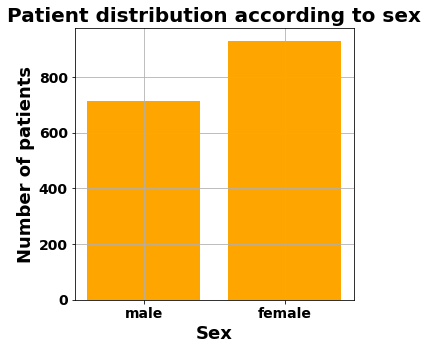

In [ ]:
fig = plt.figure(figsize = (5,5))
ax = fig.gca()
plt.xlabel('Sex', fontweight = 'bold', fontsize = 18.0)
plt.ylabel('Number of patients', fontweight = 'bold', fontsize = 18.0)
plt.title('Patient distribution according to sex', fontweight = 'bold', fontsize = 20.0)
plt.xticks(fontweight = 'bold', fontsize = 14.0)
plt.yticks(fontweight = 'bold', fontsize = 14.0)
plt.grid()
plt.hist(dataset['sex'], bins = np.arange(3)-0.5, rwidth=0.8, color=['orange'])

(array([1579.,   67.]), array([-0.5,  0.5,  1.5]), <a list of 2 Patch objects>)

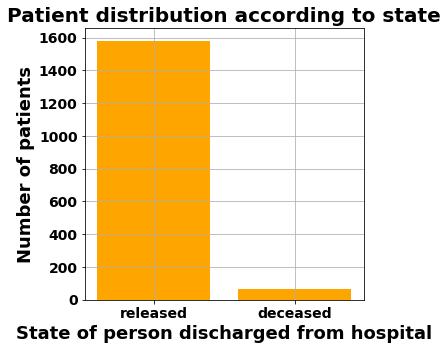

In [ ]:
fig = plt.figure(figsize = (5,5))
ax = fig.gca()
plt.xlabel('State of person discharged from hospital', fontweight = 'bold', fontsize = 18.0)
plt.ylabel('Number of patients', fontweight='bold', fontsize = 18.0)
plt.title('Patient distribution according to state', fontweight = 'bold', fontsize = 20.0)
plt.xticks(fontweight = 'bold', fontsize = 14.0)
plt.yticks(fontweight = 'bold', fontsize = 14.0)
plt.grid()
plt.hist(dataset['state'], bins = np.arange(3)-0.5, rwidth = 0.8, color = 'orange')

(array([307., 213., 418., 184., 100.,  81., 240.,  20.,  64.,  18.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]),
 <a list of 10 Patch objects>)

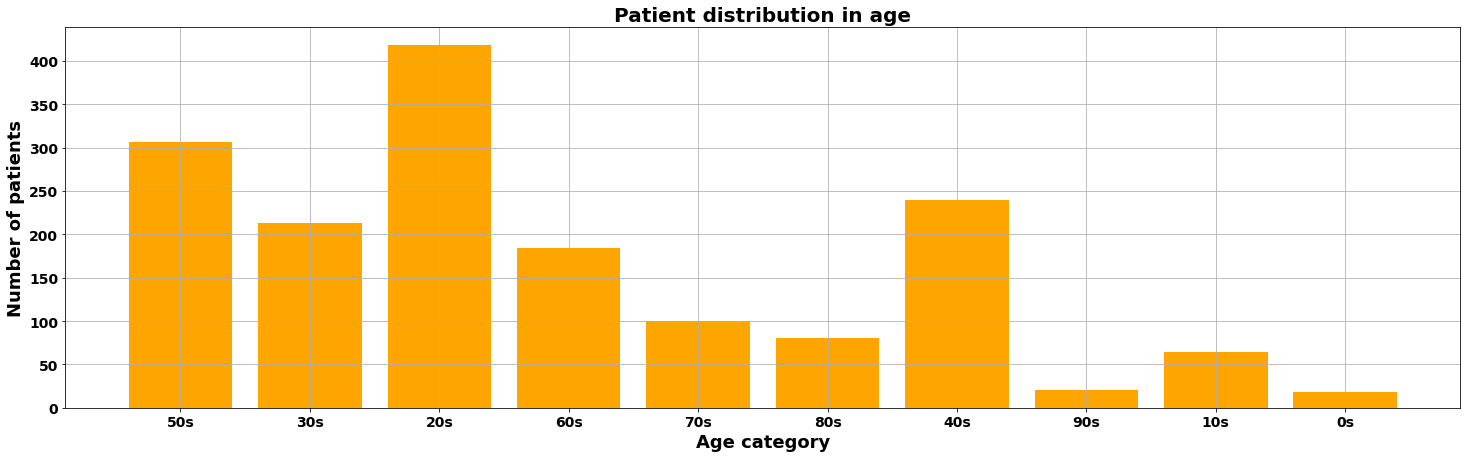

In [ ]:
fig = plt.figure(figsize = (25,7))
ax = fig.gca()
plt.xlabel('Age category', fontweight = 'bold', fontsize = 18.0)
plt.ylabel('Number of patients', fontweight = 'bold', fontsize = 18.0)
plt.xticks(fontweight = 'bold', fontsize = 14.0)
plt.yticks(fontweight = 'bold', fontsize = 14.0)
plt.grid()
plt.title('Patient distribution in age', fontweight = 'bold', fontsize = 20.0)
plt.hist(dataset['age'], bins = np.arange(11)-0.5, rwidth = 0.8, color = 'orange')

(array([189., 342., 354.,   7., 187.,   1.,  17.,  27.,   5.,  28.,   4.,
          1.,   1., 256.,  75.,  89.,   2.,   2.,  10.,  43.,   6.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5]),
 <a list of 21 Patch objects>)

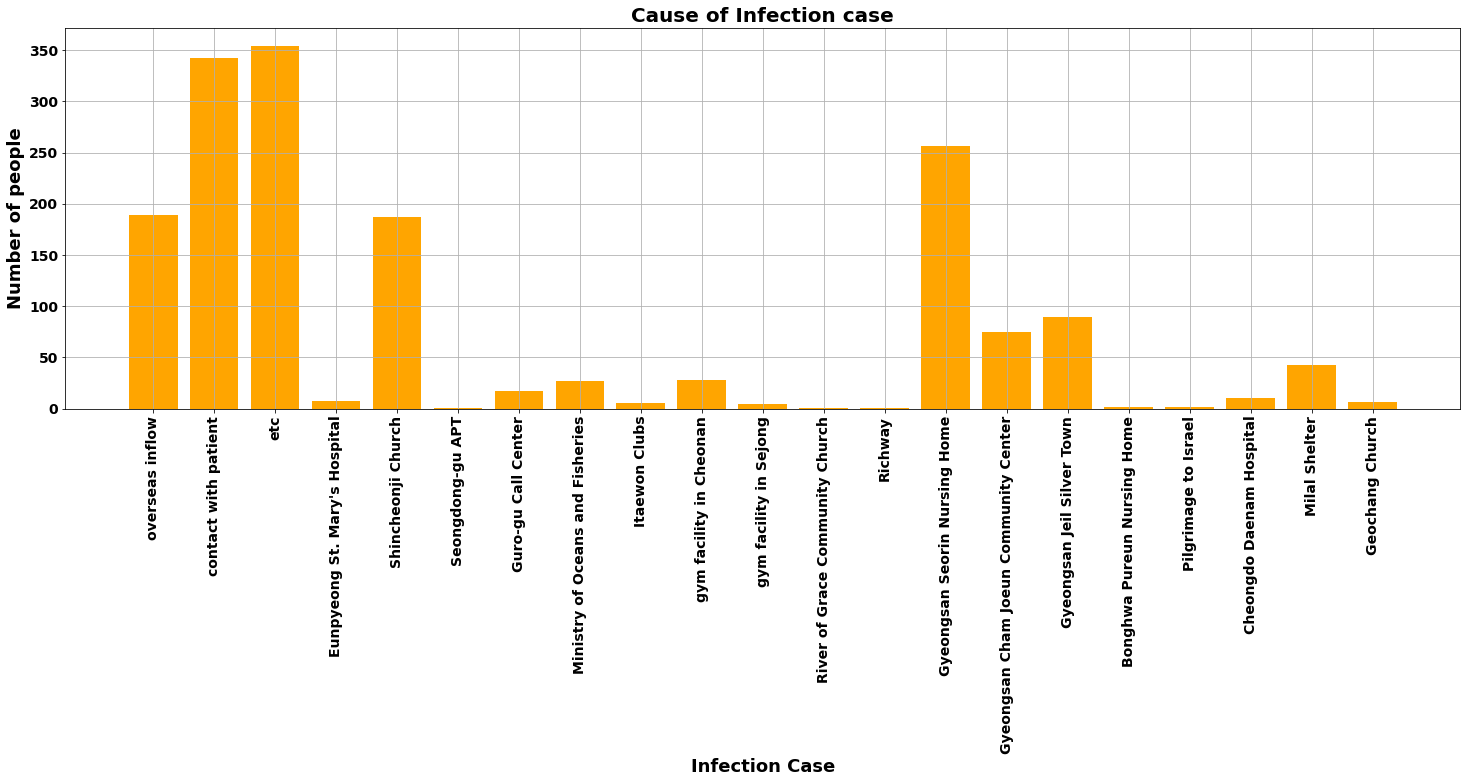

In [ ]:
fig = plt.figure(figsize = (25,7))
ax = fig.gca()
plt.ylabel('Number of people', fontweight = 'bold', fontsize = 18.0)
plt.xlabel('Infection Case', fontweight = 'bold', fontsize = 18.0)
plt.xticks(rotation = 90, fontweight = 'bold', fontsize = 14.0)
plt.yticks(fontweight = 'bold', fontsize = 14.0)
plt.grid()
plt.title('Cause of Infection case', fontweight = 'bold', fontsize = 20.0)
plt.hist(dataset['infection_case'], bins = np.arange(22)-0.5, rwidth = 0.8, color = 'orange')

## Selecting final relevant columns from array for processing data
Dataset example : [age, sex, infection, state, no_of_days]

In [ ]:
relevant_data = data[:,[0,1,2,6,7]]

## Separating relevant columns from X and Y
We aonly need no. of days and not other dates 

In [ ]:
X = relevant_data[:,[0,1,2,4]]
Y = relevant_data[:,3]
print(X[0])
print(Y[0])

[50 'male' 'overseas inflow' 13.0]
released


## Encoding Dataset
encoding dataset ref : https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

In [ ]:
#Encoding Categorical Data with Label Encoding for Gender and One hot Encoding Country 
#Lebel Encoding when there is relation btw values : male or female : gives them 0,1,2
#One Hot Encoding when there is no relation between them : Country : Makes separate column for each with binary values
# reference : https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [ ]:
le = LabelEncoder()

X[:,1] = le.fit_transform(X[:,1]) #For Gender 0 and 1
Y = le.fit_transform(Y) #For Gender 0 and 1

# define one hot encoding
encoder = OneHotEncoder(sparse=False)
ct = ColumnTransformer([('encoder', encoder, [2])],remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [ ]:
print("Before encoding X : ", X[0:5])
print("After encoding Y : ", Y[0:5])

Before encoding X :  [[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 1.0 50 1 13.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 1.0 30 1 32.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0
  0.0 0.0 0.0 50 1 20.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 1.0 20 1 16.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0
  0.0 0.0 0.0 20 0 24.0]]
After encoding Y :  [1 1 1 1 1]


# Separating Dataset into Training and testing

In [ ]:
# To create 4 separate set : 2 for training set of dependent and independent vars and same 2 for testing set
# XTrain XTest YTrain YTest

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) #80:20 :: Train:Test

print("Train set for X : ", X_train.shape)
print("Test set for X : ", X_test.shape)
print("Train set for Y : ", Y_train.shape)
print("Test set for Y : ", Y_test.shape)

Train set for X :  (1316, 24)
Test set for X :  (330, 24)
Train set for Y :  (1316,)
Test set for Y :  (330,)


# **Feature Scaling**

 to improve the performance we bring all the values in a very short range

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# Algorithmic Models

## **1.Logistic Regression** 

In [ ]:
#Creating and training the Logistic Regression model
from sklearn.linear_model import LogisticRegression   #importing LogisticRegression model from linear_model class of sklearn library
LR_classifier = LogisticRegression(random_state = 0)
LR_classifier.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
Y_pred_LR = LR_classifier.predict(X_test)

In [ ]:
cm_LR = confusion_matrix(Y_test, Y_pred_LR)
print(cm_LR)
print(accuracy_score(Y_test, Y_pred_LR)*100, "% accuracy is achieved")

[[  5   5]
 [  2 318]]
97.87878787878788 % accuracy is achieved


Text(42.0, 0.5, 'Truth')

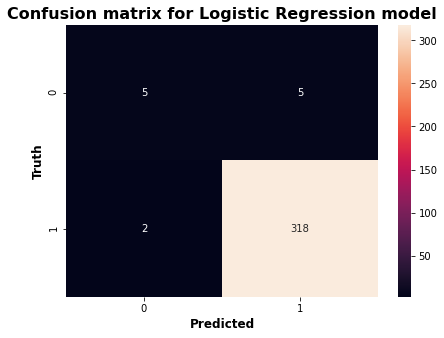

In [ ]:
plt.figure(figsize = (7,5))
sn.heatmap(cm_LR, annot = True, fmt = 'd')
plt.title('Confusion matrix for Logistic Regression model', fontweight = 'bold', fontsize = 16)
plt.xlabel('Predicted', fontweight = 'bold', fontsize = 12)
plt.ylabel('Truth', fontweight = 'bold', fontsize = 12)

### K-Fold Cross validation

Distinct accuracies for SVM :  [ 97.72727273  96.96969697  97.72727273  96.96969697 100.
  99.24242424  96.94656489  99.23664122  97.70992366  96.94656489]
Average Accuracy SVM : 97.95 %
Standard Deviation in SVM accuracies : 1.08 %


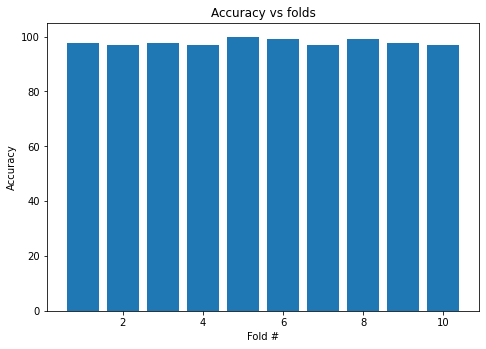

In [ ]:
# For SVM
from sklearn.model_selection import cross_val_score
lr_accuracies = cross_val_score(estimator = LR_classifier, X = X_train, y = Y_train, cv = 10)
print("Distinct accuracies for SVM : ", lr_accuracies*100)
print("Average Accuracy SVM : {:.2f} %".format(lr_accuracies.mean()*100))
print("Standard Deviation in SVM accuracies : {:.2f} %".format(lr_accuracies.std()*100))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(1,len(lr_accuracies)+1), lr_accuracies*100)
plt.xlabel("Fold #")
plt.ylabel("Accuracy")
plt.title("Accuracy vs folds")
plt.show()

## SVM

In [ ]:
from sklearn.svm import SVC
SV_classifier = SVC(kernel = 'linear', random_state = 0)
SV_classifier.fit(X_train, Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

### Hyper parameter tuning

In [ ]:
parameters = [{'C' : [0.25, 0.5, 0.75, 1], 'kernel' : ['linear']},
              {'C' : [0.25, 0.5, 0.75, 1], 'kernel' : ['rbf'], 'gamma' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]

grid_search = GridSearchCV(estimator = SV_classifier, param_grid = parameters, scoring = 'accuracy', cv = 10, n_jobs = -1) # n_jobs : use all processors
grid_search.fit(X_train, Y_train)
best_accuracy = grid_search.best_score_
best_params = grid_search.best_params_

print("BEST Accuracy SVM : {:.2f} %".format(best_accuracy*100))
print("BEST params for SVM : ", best_params)

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.4f (+/-%0.04f) for %r"% (mean*100, std*100*2, params))

BEST Accuracy SVM : 98.18 %
BEST params for SVM :  {'C': 0.5, 'kernel': 'linear'}
98.0245 (+/-2.5603) for {'C': 0.25, 'kernel': 'linear'}
98.1760 (+/-2.1722) for {'C': 0.5, 'kernel': 'linear'}
98.1760 (+/-2.1722) for {'C': 0.75, 'kernel': 'linear'}
98.1760 (+/-2.1722) for {'C': 1, 'kernel': 'linear'}
96.2763 (+/-0.8250) for {'C': 0.25, 'gamma': 0.1, 'kernel': 'rbf'}
96.4278 (+/-1.1955) for {'C': 0.25, 'gamma': 0.2, 'kernel': 'rbf'}
96.4278 (+/-1.1955) for {'C': 0.25, 'gamma': 0.3, 'kernel': 'rbf'}
96.4278 (+/-1.1955) for {'C': 0.25, 'gamma': 0.4, 'kernel': 'rbf'}
96.4278 (+/-1.1955) for {'C': 0.25, 'gamma': 0.5, 'kernel': 'rbf'}
96.4278 (+/-1.1955) for {'C': 0.25, 'gamma': 0.6, 'kernel': 'rbf'}
96.4284 (+/-0.6991) for {'C': 0.25, 'gamma': 0.7, 'kernel': 'rbf'}
96.3526 (+/-0.6061) for {'C': 0.25, 'gamma': 0.8, 'kernel': 'rbf'}
96.3526 (+/-0.6061) for {'C': 0.25, 'gamma': 0.9, 'kernel': 'rbf'}
97.0356 (+/-1.9829) for {'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}
97.1877 (+/-1.9361) for {'C':

In [ ]:
Y_pred_SVM = SV_classifier.predict(X_test)

In [ ]:
cm_SVM = confusion_matrix(Y_test, Y_pred_SVM)
print(cm_SVM)
print(accuracy_score(Y_test, Y_pred_SVM)*100, "% accuracy is achieved")

[[  7   3]
 [  1 319]]
98.7878787878788 % accuracy is achieved


Text(42.0, 0.5, 'Truth')

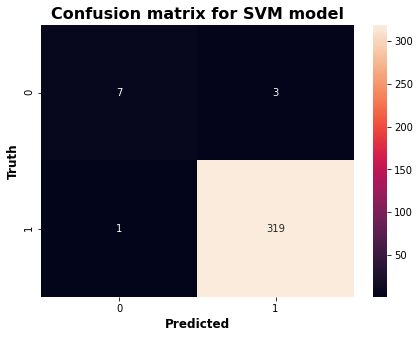

In [ ]:
plt.figure(figsize = (7,5))
sn.heatmap(cm_SVM, annot = True, fmt = 'd')
plt.title('Confusion matrix for SVM model', fontweight = 'bold', fontsize = 16)
plt.xlabel('Predicted', fontweight = 'bold', fontsize = 12)
plt.ylabel('Truth', fontweight = 'bold', fontsize = 12)

### K-Fold Cross Validation for SVM

Distinct accuracies for SVM :  [ 97.72727273  96.96969697  97.72727273  97.72727273 100.
  99.24242424  97.70992366 100.          97.70992366  96.94656489]
Average Accuracy SVM : 98.18 %
Standard Deviation in SVM accuracies : 1.09 %


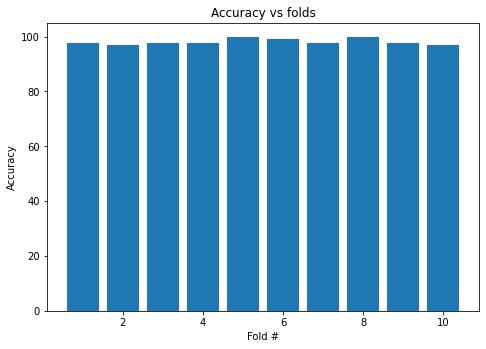

In [ ]:
# For SVM
from sklearn.model_selection import cross_val_score
svm_accuracies = cross_val_score(estimator = SV_classifier, X = X_train, y = Y_train, cv = 10)
print("Distinct accuracies for SVM : ", svm_accuracies*100)
print("Average Accuracy SVM : {:.2f} %".format(svm_accuracies.mean()*100))
print("Standard Deviation in SVM accuracies : {:.2f} %".format(svm_accuracies.std()*100))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(1,len(svm_accuracies)+1), svm_accuracies*100)
plt.xlabel("Fold #")
plt.ylabel("Accuracy")
plt.title("Accuracy vs folds")
plt.show()

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
dt_classifier.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

### Hyper-parameter tuning


In [ ]:
# Creating Parameter Space
# Creating a list of a sequence of integers from 1 to 30 (the number of features in X + 1)
n_components = list(range(1,X_train.shape[1]+1,1))

# Creating lists of parameter for Decision Tree Classifier
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

parameters = {'criterion' : criterion, 'max_depth' : max_depth}

grid_search = GridSearchCV(estimator = dt_classifier, param_grid = parameters, 
                           scoring = 'accuracy', cv = 10, n_jobs = -1)
grid_search.fit(X_train, Y_train)
best_accuracy = grid_search.best_score_
best_params = grid_search.best_params_

print("BEST Accuracy Random Forest : {:.2f} %".format(best_accuracy*100))
print("BEST params for Random Forest : ", best_params)

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.4f (+/-%0.04f) for %r"% (mean*100, std*100*2, params))

In [ ]:
y_pred_DT = dt_classifier.predict(X_test)

In [ ]:
cm_DT = confusion_matrix(Y_test, y_pred_DT)
print(cm_DT)
print(accuracy_score(Y_test, y_pred_DT)*100, "% accuracy is achieved")

In [ ]:
plt.figure(figsize = (7,5))
sn.heatmap(cm_DT, annot = True, fmt = 'd')
plt.title('Confusion matrix for Decision Tree model', fontweight = 'bold', fontsize = 16)
plt.xlabel('Predicted', fontweight = 'bold', fontsize = 12)
plt.ylabel('Truth', fontweight = 'bold', fontsize = 12)

### K-Fold Cross Validation



In [ ]:
# For SVM
from sklearn.model_selection import cross_val_score
dt_accuracies = cross_val_score(estimator = dt_classifier, X = X_train, y = Y_train, cv = 10)
print("Distinct accuracies for SVM : ", dt_accuracies*100)
print("Average Accuracy SVM : {:.2f} %".format(dt_accuracies.mean()*100))
print("Standard Deviation in SVM accuracies : {:.2f} %".format(dt_accuracies.std()*100))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(1,len(dt_accuracies)+1), dt_accuracies*100)
plt.xlabel("Fold #")
plt.ylabel("Accuracy")
plt.title("Accuracy vs folds")
plt.show()

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, Y_train)

In [ ]:
y_pred_NB = nb_classifier.predict(X_test)

In [ ]:
cm_NB = confusion_matrix(Y_test, y_pred_NB)
print(cm_NB)
print(accuracy_score(Y_test, y_pred_NB),"% accuracy is achieved")

In [ ]:
plt.figure(figsize = (7,5))
sn.heatmap(cm_NB, annot = True, fmt = 'd')
plt.title('Confusion matrix for Naive Bayes model', fontweight = 'bold', fontsize = 16)
plt.xlabel('Predicted', fontweight = 'bold', fontsize = 12)
plt.ylabel('Truth', fontweight = 'bold', fontsize = 12)

### K-Fold Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
nb_accuracies = cross_val_score(estimator = nb_classifier, X = X_train, y = Y_train, cv = 10)
print("Distinct accuracies for NB : ", nb_accuracies*100)
print("Average Accuracy NB : {:.2f} %".format(nb_accuracies.mean()*100))
print("Standard Deviation in NB accuracies : {:.2f} %".format(nb_accuracies.std()*100))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(1,len(nb_accuracies)+1), nb_accuracies*100)
plt.xlabel("Fold #")
plt.ylabel("Accuracy")
plt.title("Accuracy vs folds")
plt.show()

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
rf_classifier.fit(X_train, Y_train)

### Hyper prameter tuning

In [ ]:
parameters = {'max_depth': [10], 'n_estimators': [40, 50, 70, 80, 100, 120, 150, 170, 200]}

grid_search = GridSearchCV(estimator = rf_classifier, param_grid = parameters, 
                           scoring = 'accuracy', cv = 10, n_jobs = -1)
grid_search.fit(X_train, Y_train)
best_accuracy = grid_search.best_score_
best_params = grid_search.best_params_

print("BEST Accuracy Random Forest : {:.2f} %".format(best_accuracy*100))
print("BEST params for Random Forest : ", best_params)

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.4f (+/-%0.04f) for %r"% (mean*100, std*100*2, params))

In [ ]:
y_pred_RF = rf_classifier.predict(X_test)

In [ ]:
cm_RF = confusion_matrix(Y_test, y_pred_RF)
print(cm_RF)
accuracy_score(Y_test, y_pred_RF)

In [ ]:
plt.figure(figsize = (7,5))
sn.heatmap(cm_RF, annot = True, fmt = 'd')
plt.xlabel('Predicted', fontweight = 'bold', fontsize = 12)
plt.title('Confusion matrix for Random Forest model', fontweight = 'bold', fontsize = 16)
plt.ylabel('Truth', fontweight = 'bold', fontsize = 12)

### K-Fold Cross validatoin

In [ ]:
from sklearn.model_selection import cross_val_score
rf_accuracies = cross_val_score(estimator = rf_classifier, X = X_train, y = Y_train, cv = 10)
print("Distinct accuracies for NB : ", rf_accuracies*100)
print("Average Accuracy NB : {:.2f} %".format(rf_accuracies.mean()*100))
print("Standard Deviation in NB accuracies : {:.2f} %".format(rf_accuracies.std()*100))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(1,len(rf_accuracies)+1), rf_accuracies*100)
plt.xlabel("Fold #")
plt.ylabel("Accuracy")
plt.title("Accuracy vs folds")
plt.show()

## K-Nearest Neighbours

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors = 10, metric = 'minkowski', p = 2)
knn_classifier.fit(X_train, Y_train)

### Hyper parameter tuning

In [ ]:
parameters = {'n_neighbors': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50], 'metric' : ['minkowski'], 'p' : [2]}

grid_search = GridSearchCV(estimator = knn_classifier, param_grid = parameters, 
                           scoring = 'accuracy', cv = 10, n_jobs = -1)
grid_search.fit(X_train, Y_train)
best_accuracy = grid_search.best_score_
best_params = grid_search.best_params_

print("BEST Accuracy KNN : {:.2f} %".format(best_accuracy*100))
print("BEST params for KNN : ", best_params)

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.4f (+/-%0.04f) for %r"% (mean*100, std*100*2, params))

BEST Accuracy KNN : 97.57 %
BEST params for KNN :  {'metric': 'minkowski', 'n_neighbors': 5, 'p': 2}
97.5682 (+/-2.6132) for {'metric': 'minkowski', 'n_neighbors': 5, 'p': 2}
96.8847 (+/-2.0936) for {'metric': 'minkowski', 'n_neighbors': 10, 'p': 2}
96.4278 (+/-1.1955) for {'metric': 'minkowski', 'n_neighbors': 15, 'p': 2}
96.4278 (+/-1.1955) for {'metric': 'minkowski', 'n_neighbors': 20, 'p': 2}
96.2763 (+/-0.8250) for {'metric': 'minkowski', 'n_neighbors': 25, 'p': 2}
96.2763 (+/-0.8250) for {'metric': 'minkowski', 'n_neighbors': 30, 'p': 2}
95.6697 (+/-0.6727) for {'metric': 'minkowski', 'n_neighbors': 35, 'p': 2}
95.6697 (+/-0.6727) for {'metric': 'minkowski', 'n_neighbors': 40, 'p': 2}
95.6697 (+/-0.6727) for {'metric': 'minkowski', 'n_neighbors': 45, 'p': 2}
95.6697 (+/-0.6727) for {'metric': 'minkowski', 'n_neighbors': 50, 'p': 2}


In [ ]:
y_pred_KNN = knn_classifier.predict(X_test)

In [ ]:
cm_KNN = confusion_matrix(Y_test, y_pred_KNN)
print(cm_KNN)
print(accuracy_score(Y_test, y_pred_KNN)*100, "% accuracy is achieved")

[[  7   3]
 [  2 318]]
98.48484848484848 % accuracy is achieved


Text(42.0, 0.5, 'Truth')

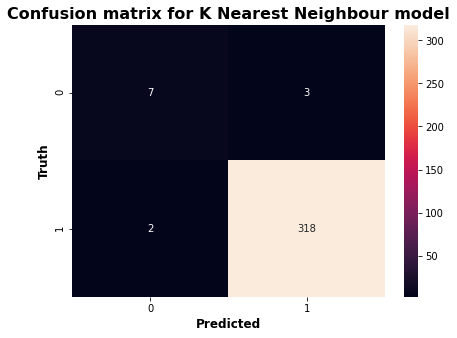

In [ ]:
plt.figure(figsize = (7,5))
sn.heatmap(cm_KNN, annot = True, fmt = 'd')
plt.title('Confusion matrix for K Nearest Neighbour model', fontweight = 'bold', fontsize = 16)
plt.xlabel('Predicted', fontweight = 'bold', fontsize = 12)
plt.ylabel('Truth', fontweight = 'bold', fontsize = 12)

### K-Fold Cross validation for KNN

Distinct accuracies for KNN :  [96.21212121 96.21212121 97.72727273 96.96969697 97.72727273 96.21212121
 95.41984733 99.23664122 96.94656489 96.18320611]
Average Accuracy KNN : 96.88 %
Standard Deviation in KNN accuracies : 1.05 %


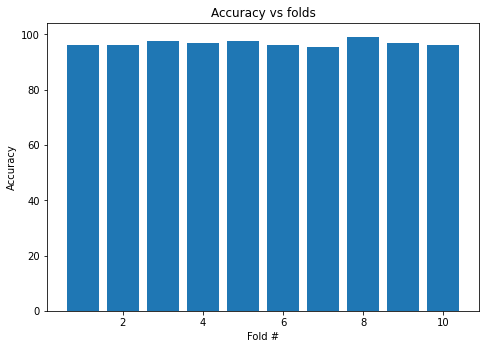

In [ ]:
from sklearn.model_selection import cross_val_score
knn_accuracies = cross_val_score(estimator = knn_classifier, X = X_train, y = Y_train, cv = 10)
print("Distinct accuracies for KNN : ", knn_accuracies*100)
print("Average Accuracy KNN : {:.2f} %".format(knn_accuracies.mean()*100))
print("Standard Deviation in KNN accuracies : {:.2f} %".format(knn_accuracies.std()*100))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(1,len(knn_accuracies)+1), knn_accuracies*100)
plt.xlabel("Fold #")
plt.ylabel("Accuracy")
plt.title("Accuracy vs folds")
plt.show()